# Random Forest

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, balanced_accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import pandas as pd

In [5]:
df = pd.read_csv('df.csv')

In [50]:
# Separate the 'status_code' column (target) and features
X = df.drop(columns=['status_code'])
y = df['status_code']

# Identify categorical and numerical columns
categorical_columns = X.select_dtypes(include=['object']).columns
numerical_columns = X.select_dtypes(include=['number']).columns

# OneHotEncode categorical columns
encoder = OneHotEncoder(sparse_output=False)
encoded_categorical = encoder.fit_transform(X[categorical_columns])

# Create DataFrame from encoded categorical data
encoded_categorical_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(categorical_columns))

# Standardize numerical columns
scaler = StandardScaler()
scaled_numerical = scaler.fit_transform(X[numerical_columns])

# Create DataFrame from scaled numerical data
scaled_numerical_df = pd.DataFrame(scaled_numerical, columns=numerical_columns)

# Combine encoded categorical and scaled numerical data
processed_df = pd.concat([encoded_categorical_df, scaled_numerical_df], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(processed_df, y, test_size=0.2, random_state=20)#,stratify=df['status_code'])


Fitting 5 folds for each of 72 candidates, totalling 360 fits
AUC-ROC: 0.8
Accuracy: 0.74
Precision: 0.8319327731092437
Recall: 0.7734375
F1 Score: 0.8016194331983806
Ballanced Accuracy:0.71
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.65      0.60        57
           1       0.83      0.77      0.80       128

    accuracy                           0.74       185
   macro avg       0.70      0.71      0.70       185
weighted avg       0.75      0.74      0.74       185



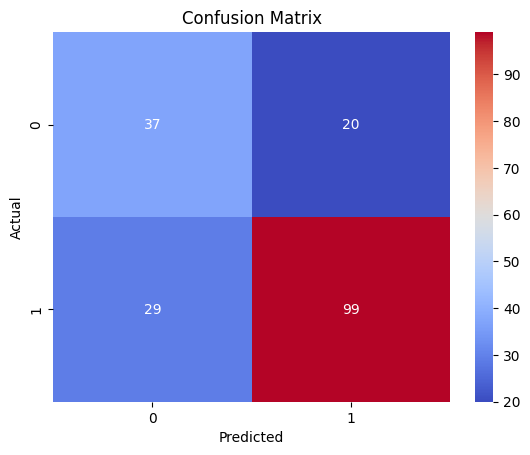

In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define hyperparameters for tuning
param_grid = {
    'n_estimators': [150,200,250],
    'max_depth': [35,40,45],
    'min_samples_split': [2,3],
    'min_samples_leaf': [2, 4],
    'bootstrap': [True, False]
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_rf_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred = best_rf_model.predict(X_test)
y_prob = best_rf_model.predict_proba(X_test)[:, 1]

# Evaluate the best model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_prob)
report = classification_report(y_test, y_pred)

# Display metrics
print(f'AUC-ROC: {round(auc_roc, 2)}')
print(f'Accuracy: {round(accuracy, 2)}')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Ballanced Accuracy:{round(balanced_accuracy_score(y_test, y_pred),2)}")
print('Classification Report:')
print(report)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt=".0f", cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [59]:
# Print the best hyperparameters found by GridSearchCV
print("Best hyperparameters found:")
print(grid_search.best_params_)

# Print cross-validation results
cv_results = grid_search.cv_results_

# Convert to DataFrame for better visualization
cv_results_df = pd.DataFrame(cv_results)

# Display the top results sorted by mean test score (AUC-ROC)
cv_results_df[['params', 'mean_test_score', 'std_test_score']].sort_values(by='mean_test_score', ascending=False).head()


Best hyperparameters found:
{'bootstrap': False, 'max_depth': 45, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150}


,params,mean_test_score,std_test_score
63,"{'bootstrap': False, 'max_depth': 45, 'min_sam...",0.806379,0.046805
60,"{'bootstrap': False, 'max_depth': 45, 'min_sam...",0.806379,0.046805
51,"{'bootstrap': False, 'max_depth': 40, 'min_sam...",0.806298,0.046853
48,"{'bootstrap': False, 'max_depth': 40, 'min_sam...",0.806298,0.046853
39,"{'bootstrap': False, 'max_depth': 35, 'min_sam...",0.806139,0.046887


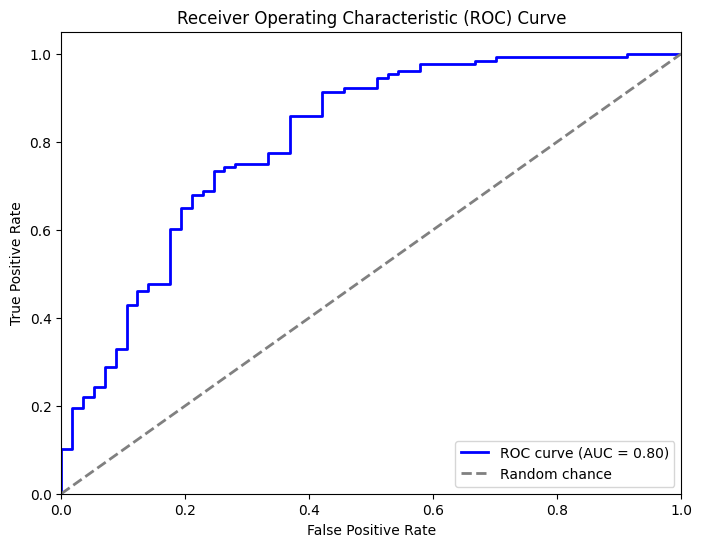

In [61]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities for the positive class
y_prob = best_rf_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random chance')

# Adding labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Show plot
plt.show()
